In [3]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

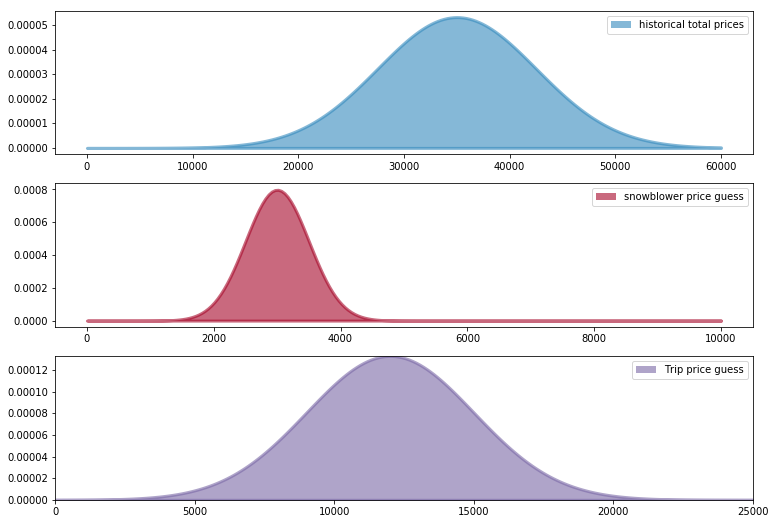

In [2]:
figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x, 0, norm_pdf(x, 35000, 7500), 
                color = "#348ABD", lw = 3, alpha = 0.6,
                label = "historical total prices")
p1 = plt.Rectangle((0,0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x, 0, norm_pdf(x, 3000, 500), 
                 color = "#A60628", lw = 3, alpha = 0.6,
                 label="snowblower price guess")

p2 = plt.Rectangle((0,0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x, 0, norm_pdf(x, 12000, 3000),
                color = "#7A68A6", lw = 3, alpha = 0.6,
                label = "Trip price guess")
plt.autoscale(tight=True)
p3 = plt.Rectangle((0,0), 1, 1, fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()])

In [4]:
data_mu = [3e3, 12e3]

data_std = [5e2, 3e3]

mu_prior = 35e3
std_prior = 75e2

with pm.Model() as model:
    true_price = pm.Normal("true_price", mu=mu_prior, sd=std_prior)
    
    prize_1 = pm.Normal("first_prize", mu=data_mu[0], sd=data_std[0])
    prize_2 = pm.Normal("second_prize", mu=data_mu[1], sd=data_std[1])
    price_estimate = prize_1 + prize_2
    
    logp = pm.Normal.dist(mu=price_estimate, sd=(3e3)).logp(true_price)
    error = pm.Potential("error", logp)
    
    trace = pm.sample(50000, step=pm.Metropolis())
    burned_trace = trace[10000:]
    
price_trace = burned_trace["true_price"]

100%|██████████| 50500/50500 [00:17<00:00, 2813.42it/s]


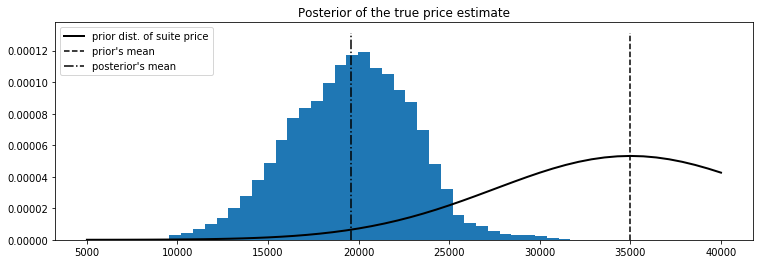

In [5]:
figsize(12.5, 4)

x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c = "k", lw = 2, label = "prior dist. of suite price")

_hist = plt.hist(price_trace, bins=35, normed=True, histtype="stepfilled")
plt.title("Posterior of the true price estimate")
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), label="prior's mean", linestyles="--")
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]), label="posterior's mean", linestyles="-.")
plt.legend(loc="upper left")